In [42]:
!pip install langgraph langchain-neo4j


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [43]:
# --- Install and Imports ---
import os
import neo4j
import re
import pprint
from langgraph.graph import StateGraph, END
#from langgraph.state import State
from typing import Dict, List, Optional
from langchain_groq import ChatGroq
from langchain_neo4j import GraphCypherQAChain, Neo4jGraph
from langchain.prompts import PromptTemplate
from pydantic import BaseModel
from typing import List, Optional

In [44]:
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

True

In [45]:
# --- Set up GROQ API Key ---
if "GROQ_API_KEY" not in os.environ:
    print("GROQ_API_KEY not found in environment variables. Please set it in the .env file.")
    # os.environ["GROQ_API_KEY"] = "replace_with_your_groq_api_key"  # Uncomment and set your key if needed

In [46]:
# --- Neo4j connection ---
NEO4J_URI = "bolt://localhost:7687"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "neo4j1999"
NEO4J_DATABASE = "graphreader1"
driver = neo4j.GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

# --- Initialize ChatGroq LLM ---
llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    #"meta-llama/llama-4-maverick-17b-128e-instruct",
    #"qwen/qwen3-32b",
    #"meta-llama/llama-4-scout-17b-16e-instruct",
    #"deepseek-r1-distill-llama-70b",
    temperature=0,
    max_tokens=None,
    #reasoning_format="parsed",
    timeout=None,
    max_retries=2,
)

enhanced_graph = Neo4jGraph(
        url = NEO4J_URI,
        username = NEO4J_USER,
        password = NEO4J_PASSWORD,
        database = NEO4J_DATABASE,
        enhanced_schema=True,
    )

In [47]:
CYPHER_GENERATION_PROMPT = """Task: Generate a Cypher statement to query a Neo4j graph database.


Instructions:
- Extract the patient id(s) from the input question (e.g., "patient P002" → "P002").
- Use the extracted id(s) in the Cypher query.
- Do not use the id(s) from the example, always use the id(s) from the input question.
- Do not output <PATIENT_ID> or {{patient_id}} in your answer. Use the actual id(s) from the question.
- Only output the Cypher statement, nothing else.


Schema:
{{schema}}


Examples:
# If the input is:
# What are the recent health updates for patient P002?
MATCH (p:Patient)
WHERE toLower(p.id) CONTAINS toLower('P002')
RETURN p


# If the input is:
# What are the recent health updates for patient P025?
MATCH (p:Patient)
WHERE toLower(p.id) CONTAINS toLower('P025')
RETURN p


The input is:
{{question}}
"""
cypher_prompt_template = PromptTemplate(
    template=CYPHER_GENERATION_PROMPT,
    input_variables=["schema", "question"]
)

In [48]:
chain = GraphCypherQAChain.from_llm(
        llm=llm,
        graph=enhanced_graph,
        cypher_prompt = cypher_prompt_template,
        validate_cypher=True,
        return_intermediate_steps=True,
        allow_dangerous_requests=True,
        verbose=True
    )

In [49]:
class DomainSelection(BaseModel):
    domains: List[str]
    reasoning: Optional[str] = None
class RetrievalState(BaseModel):
    question: str
    is_patient_related: bool = False
    patient_ids: List[str] = []
    domains: List[str] = []
    notebook: List[str] = []
    cypher_query: Optional[str] = None
    answer: Optional[str] = None
    exploration_step: str = "classify"
    traversal_count: int = 0
    traversal_limit: int = 3

In [50]:
# --- Helper for LLM calls ---
def groq_chat(system_prompt, user_prompt):
    messages = [
        ("system", system_prompt),
        ("human", user_prompt)
    ]
    return llm.invoke(messages).content
def extract_patient_ids(question):
    # Handles "patient P002", "patients P002 and P003", "patients P002, P003"
    ids = re.findall(r'patient[s]?\s+((?:[A-Za-z0-9]+(?:\s*(?:,|and)\s*)?)*)', question, re.IGNORECASE)
    if ids:
        # Split by comma or 'and'
        id_str = ids[0]
        found_ids = re.split(r',|\band\b', id_str)
        found_ids = [i.strip() for i in found_ids if i.strip()]
        print(f"Extracted patient IDs: {found_ids}")
        return found_ids
    # Handle "all patients" or "patients" without ids
    if re.search(r'\ball patients\b', question, re.IGNORECASE) or re.search(r'\bpatients\b', question, re.IGNORECASE):
        return ["ALL"]
    return []


In [ ]:
# --- Workflow Nodes ---
def classify_question(state: RetrievalState):
    system_prompt = "You are a classifier."
    user_prompt = f"Does the question '{state.question}' pertain to patient data? Answer with 'yes' or 'no'."
    response = groq_chat(system_prompt, user_prompt)
    state.is_patient_related = "yes" in response.lower()
    state.notebook = [f"Classified as {'patient-related' if state.is_patient_related else 'generic'}."]
    state.exploration_step = "initialize" if state.is_patient_related else "generic_answer"
    return state

def generic_answer(state: RetrievalState):
    system_prompt = "You are a helpful assistant."
    user_prompt = f"Provide a generic answer to: {state.question}"
    state.answer = groq_chat(system_prompt, user_prompt).strip()
    return state

def initialize_retrieval(state: RetrievalState):
    with driver.session(database=NEO4J_DATABASE) as session:
        patient_ids = extract_patient_ids(state.question)
        if patient_ids:
            if patient_ids == ["ALL"]:
                cypher = "MATCH (p:Patient) RETURN p"
            elif len(patient_ids) == 1:
                cypher = f"MATCH (p:Patient) WHERE toLower(p.id) = toLower('{patient_ids[0]}') RETURN p"
            else:
                ids_list = ', '.join([f"toLower('{pid}')" for pid in patient_ids])
                cypher = (
                    "MATCH (p:Patient) "
                    "WHERE toLower(p.id) IN [" +ids_list+ "]"
                    "RETURN p"
                )
            state.cypher_query = cypher
            print(f"Generated Cypher query: {cypher}")
            result = session.run(cypher)
            records = list(result)
            print(f"Cypher query result: {records}")
            pprint.pprint(records)  # Print the result for debugging
            state.patient_ids = []
            for r in records:
                try:
                    state.patient_ids.append(r["p"]["id"])
                except (KeyError, TypeError):
                    pass
            state.notebook.append(f"Identified patients: {state.patient_ids}")
            print(f"Identified patient IDs: {state.patient_ids}")
        else:
            # fallback to LLM-based Cypher generation
            # Had to use primarily regex to find initial node coz the Cypher generation was not reliable with all opensource LLMs
            # This works fairly well for Claude & OpenAI in production scenarios
            result = chain.invoke({
                "query": state.question,
                "schema": enhanced_graph.schema
            })
            cypher = result.get('intermediate_steps', [{}])[0].get('query', [])
            state.cypher_query = cypher
            result = session.run(cypher)
            state.patient_ids = [r["id"] for r in result if "id" in r]
            state.notebook.append(f"Identified patients: {state.patient_ids}")
    state.exploration_step = "select_domains"
    return state

def select_domains(state: RetrievalState):
    if not state.patient_ids:
        state.answer = "No patient data found."
        return state
    system_prompt = (
        "You are a domain selector. "
        "Given a question, return a JSON object with two fields: "
        "'domains' (a list of relevant domain names from ['Conversations','History','Behaviour']) "
        "and 'reasoning' (a brief explanation). "
        "Only use the provided domain names."
    )
    user_prompt = f"Question: {state.question}\nReturn JSON."
    response = groq_chat(system_prompt, user_prompt)
    print(f"Domains response: {response}")
    # --- Clean response: remove markdown code fencing if present ---
    cleaned = response.strip()
    if cleaned.startswith("```"):
        cleaned = cleaned.strip("`")
        # Remove possible language tag (e.g., ```json)
        cleaned = re.sub(r'^json\n', '', cleaned, flags=re.IGNORECASE)
        cleaned = cleaned.strip()
    try:
        parsed = DomainSelection.model_validate_json(cleaned)
        state.domains = parsed.domains
        state.notebook.append(f"Selected domains: {state.domains}")
        state.notebook.append(f"Domain selection reasoning: {parsed.reasoning}")
        print(f"Selected domains: {state.domains}")
    except Exception as e:
        print(f"Failed to parse domains: {e}")
        # fallback: try to extract domains from text
        state.domains = [d.strip() for d in response.split(",") if d.strip()]
        state.notebook.append(f"Selected domains: {state.domains}")
    state.exploration_step = "cross_check_facts"
    return state


def cross_check_facts(state: RetrievalState):
    with driver.session(database=NEO4J_DATABASE) as session:
        facts = []
        for patient_id in state.patient_ids:
            for domain in state.domains:
                result = session.run(
                    "MATCH (p:Patient {id: $patient_id})-[:HAS_DOMAIN]->(d:Domain {name: $domain})-[:CONTAINS_FACT]->(f:AtomicFact) "
                    "RETURN f.fact AS fact",
                    patient_id=patient_id, domain=domain
                )
                facts.extend([r["fact"] for r in result])
                print(f"Found {len(facts)} facts for patient {patient_id} in domain {domain}")
        state.notebook.append(f"Cross-checked facts: {facts[:3]}... (total {len(facts)})")
    state.exploration_step = "compile_answer"
    return state


def compile_answer(state: RetrievalState):
    facts_text = "\n".join(state.notebook)
    system_prompt = "You are a summarizer."
    user_prompt = f"Question: {state.question}\nFacts: {facts_text}\nCompile an answer."
    state.answer = groq_chat(system_prompt, user_prompt).strip()
    print(f"Compiled answer: {state.answer}")
    state.exploration_step = "evaluate_answer"
    return state


def evaluate_answer(state: RetrievalState):
    # Check traversal limit before asking LLM
    if state.traversal_count >= state.traversal_limit:
        print("Traversal limit reached in evaluate_answer, stopping.")
        state.notebook.append("Traversal limit reached, stopping exploration.")
        state.exploration_step = END
        return state

    system_prompt = "You are an evaluator."
    user_prompt = f"Question: {state.question}\nAnswer: {state.answer}\nIs this answer sufficient, or should more exploration be done? Answer with 'sufficient' or 'explore more'."
    decision = groq_chat(system_prompt, user_prompt).strip().lower()
    if decision == "explore more":
        print("Decided to explore more based on the current answer.")
        state.notebook.append("Decided to explore more based on current answer.")
        state.exploration_step = "traverse_further"
    else:
        print("Answer deemed sufficient.")
        state.notebook.append("Answer deemed sufficient.")
        state.exploration_step = END
    return state

def traverse_by_keyentity(state: RetrievalState):
    state.traversal_count += 1
    if state.traversal_count >= state.traversal_limit:
        state.notebook.append("Traversal limit reached, compiling final answer.")
        state.exploration_step = END
        return state
    with driver.session(database=NEO4J_DATABASE) as session:
        new_facts = []
        for patient_id in state.patient_ids:
            result = session.run(
                """
                MATCH (p:Patient {id: $patient_id})-[:HAS_DOMAIN]->(d:Domain)-[:CONTAINS_FACT]->(f1:AtomicFact)-[:HAS_ENTITY]->(e:KeyEntity)
                MATCH (e)<-[:HAS_ENTITY]-(f2:AtomicFact)
                WHERE f1 <> f2
                RETURN DISTINCT f2.fact AS fact
                """,
                patient_id=patient_id
            )
            new_facts.extend([r["fact"] for r in result])
        state.notebook.append(f"Additional facts from KeyEntity traversal: {new_facts[:3]}... (total {len(new_facts)})")
    state.exploration_step = "compile_answer"
    return state


def traverse_by_unexplored_domains(state: RetrievalState):
    state.traversal_count += 1
    if state.traversal_count >= state.traversal_limit:
        state.notebook.append("Traversal limit reached, compiling final answer.")
        state.exploration_step = END
        return state
    with driver.session(database=NEO4J_DATABASE) as session:
        new_facts = []
        for patient_id in state.patient_ids:
            result = session.run(
                """
                MATCH (p:Patient {id: $patient_id})-[:HAS_DOMAIN]->(d:Domain)
                WHERE NOT d.name IN $explored_domains
                MATCH (d)-[:CONTAINS_FACT]->(f:AtomicFact)
                RETURN d.name AS domain, f.fact AS fact
                """,
                patient_id=patient_id,
                explored_domains=state.domains
            )
            new_facts.extend([f"{r['domain']}: {r['fact']}" for r in result])
        state.notebook.append(f"Additional facts from unexplored domains: {new_facts[:3]}... (total {len(new_facts)})")
    state.exploration_step = "compile_answer"
    return state

In [52]:
# --- Select traversal strategy based on environment variable ---
TRAVERSAL_STRATEGY = os.environ.get("TRAVERSAL_STRATEGY", "unexplored_domains").lower()


if TRAVERSAL_STRATEGY == "keyentity":
    traverse_further = traverse_by_keyentity
else:
    traverse_further = traverse_by_unexplored_domains

In [53]:
# --- Build LangGraph workflow ---
workflow = StateGraph(RetrievalState)
workflow.add_node("classify_question", classify_question)
workflow.add_node("generic_answer", generic_answer)
workflow.add_node("initialize_retrieval", initialize_retrieval)
workflow.add_node("select_domains", select_domains)
workflow.add_node("cross_check_facts", cross_check_facts)
workflow.add_node("compile_answer", compile_answer)
workflow.add_node("evaluate_answer", evaluate_answer)
workflow.add_node("traverse_further", traverse_further)
workflow.set_entry_point("classify_question")
workflow.add_conditional_edges(
    "classify_question",
    lambda x: x.exploration_step,
    {"generic_answer": "generic_answer", "initialize": "initialize_retrieval"}
)
workflow.add_edge("generic_answer", END)
workflow.add_edge("initialize_retrieval", "select_domains")
workflow.add_edge("select_domains", "cross_check_facts")
workflow.add_edge("cross_check_facts", "compile_answer")
workflow.add_edge("compile_answer", "evaluate_answer")
workflow.add_conditional_edges(
    "evaluate_answer",
    lambda x: x.exploration_step,
    {"traverse_further": "traverse_further", END: END}
)
workflow.add_edge("traverse_further", "compile_answer")


In [54]:
# --- Compile and run ---
graph = workflow.compile()

In [55]:
#result = graph.invoke({
#   "question": "What are the recent health updates for patient P002?",
#   "traversal_limit": 2
#})

In [61]:
result = graph.invoke({"question": "What are the recent health updates for patient P003?"})

Extracted patient IDs: ['P003']
Generated Cypher query: MATCH (p:Patient) WHERE toLower(p.id) = toLower('P003') RETURN p
Cypher query result: [<Record p=<Node element_id='4:81a996ae-8579-4629-b5f2-caffd85e5472:144' labels=frozenset({'Patient'}) properties={'id': 'P003'}>>]
[<Record p=<Node element_id='4:81a996ae-8579-4629-b5f2-caffd85e5472:144' labels=frozenset({'Patient'}) properties={'id': 'P003'}>>]
Identified patient IDs: ['P003']
Domains response: ```
{
  "domains": ["Conversations", "Behaviour"],
  "reasoning": "Recent health updates for a patient would likely be discussed in conversations between healthcare professionals and the patient, and the patient's behaviour, such as adherence to treatment, can impact their health."
}
```
Selected domains: ['Conversations', 'Behaviour']
Found 8 facts for patient P003 in domain Conversations
Found 8 facts for patient P003 in domain Behaviour
Compiled answer: Based on the available information, here are the recent health updates for patient

In [64]:
result['answer']

'Based on the available information, here are the recent health updates for patient P003:\n\n* The patient discussed eczema on August 13, 2020, and was later diagnosed with eczema in 2021.\n* The patient reported a headache on April 24, 2020.\n* The patient mentioned sertraline usage on April 03, 2022.\n* The patient was prescribed metformin starting in 2021.\n* The patient had a surgery recorded on March 30, 2022.\n\nThese updates suggest that patient P003 has been experiencing skin issues (eczema), headaches, and may be managing other health conditions with medications like sertraline and metformin. The recent surgery in March 2022 may also be relevant to their current health status. Overall, patient P003 appears to have a complex medical history with multiple conditions and treatments.'

In [56]:
result = graph.invoke({"question": "What are the recent health updates for patient P002?"})

Extracted patient IDs: ['P002']
Generated Cypher query: MATCH (p:Patient) WHERE toLower(p.id) = toLower('P002') RETURN p
Cypher query result: [<Record p=<Node element_id='4:81a996ae-8579-4629-b5f2-caffd85e5472:80' labels=frozenset({'Patient'}) properties={'id': 'P002'}>>]
[<Record p=<Node element_id='4:81a996ae-8579-4629-b5f2-caffd85e5472:80' labels=frozenset({'Patient'}) properties={'id': 'P002'}>>]
Identified patient IDs: ['P002']
Domains response: ```
{
  "domains": ["Conversations", "Behaviour"],
  "reasoning": "Recent health updates for a patient would likely be discussed in conversations between healthcare professionals and the patient, and the patient's behaviour, such as adherence to treatment, can impact their health."
}
```
Selected domains: ['Conversations', 'Behaviour']
Found 8 facts for patient P002 in domain Conversations
Found 8 facts for patient P002 in domain Behaviour
Compiled answer: Recent health updates for patient P002 include discussions about gastritis on Januar

In [57]:
result1 = graph.invoke({"question": "What was the last medication for patient P025?"})

Extracted patient IDs: ['P025']
Generated Cypher query: MATCH (p:Patient) WHERE toLower(p.id) = toLower('P025') RETURN p
Cypher query result: [<Record p=<Node element_id='4:81a996ae-8579-4629-b5f2-caffd85e5472:874' labels=frozenset({'Patient'}) properties={'id': 'P025'}>>]
[<Record p=<Node element_id='4:81a996ae-8579-4629-b5f2-caffd85e5472:874' labels=frozenset({'Patient'}) properties={'id': 'P025'}>>]
Identified patient IDs: ['P025']
Domains response: ```json
{
  "domains": ["Behaviour"],
  "reasoning": "The question is about a patient's medication, which is related to their behaviour or treatment history, but since it's about a specific action or event (last medication), it falls under Behaviour."
}
```
Selected domains: ['Behaviour']
Found 0 facts for patient P025 in domain Behaviour
Compiled answer: There is no information provided about the last medication for patient P025. The available facts are classified as patient-related and the domain is selected as 'Behaviour', but there a

In [58]:
result

{'question': 'What are the recent health updates for patient P002?',
 'is_patient_related': True,
 'patient_ids': ['P002'],
 'domains': ['Conversations', 'Behaviour'],
 'notebook': ['Classified as patient-related.',
  "Identified patients: ['P002']",
  "Selected domains: ['Conversations', 'Behaviour']",
  "Domain selection reasoning: Recent health updates for a patient would likely be discussed in conversations between healthcare professionals and the patient, and the patient's behaviour, such as adherence to treatment, can impact their health.",
  "Cross-checked facts: ['The patient discussed gastritis on January 04, 2024.', 'The patient mentioned aspirin usage on December 17, 2023.', 'The patient reported fatigue on May 02, 2024.']... (total 8)",
  'Decided to explore more based on current answer.',
  "Additional facts from unexplored domains: ['History: Diagnosed with eczema in 2023.', 'History: Prescribed aspirin since 2022.', 'History: Recorded surgery on November 03, 2023.']... (

In [60]:
result1

{'question': 'What was the last medication for patient P025?',
 'is_patient_related': True,
 'patient_ids': ['P025'],
 'domains': ['Behaviour'],
 'notebook': ['Classified as patient-related.',
  "Identified patients: ['P025']",
  "Selected domains: ['Behaviour']",
  "Domain selection reasoning: The question is about a patient's medication, which is related to their behaviour or treatment history, but since it's about a specific action or event (last medication), it falls under Behaviour.",
  'Cross-checked facts: []... (total 0)',
  'Decided to explore more based on current answer.',
  "Additional facts from unexplored domains: ['Conversations: The patient discussed influenza on March 29, 2019.', 'Conversations: The patient mentioned metformin usage on November 22, 2022.', 'Conversations: The patient reported pain on February 07, 2023.']... (total 24)",
  'Decided to explore more based on current answer.',
  "Additional facts from unexplored domains: ['Conversations: The patient discus

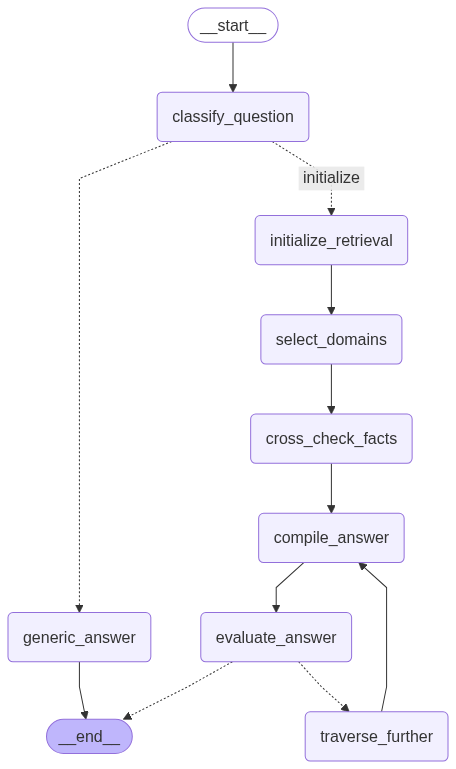

In [59]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))